In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy)

(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 0, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1])>>


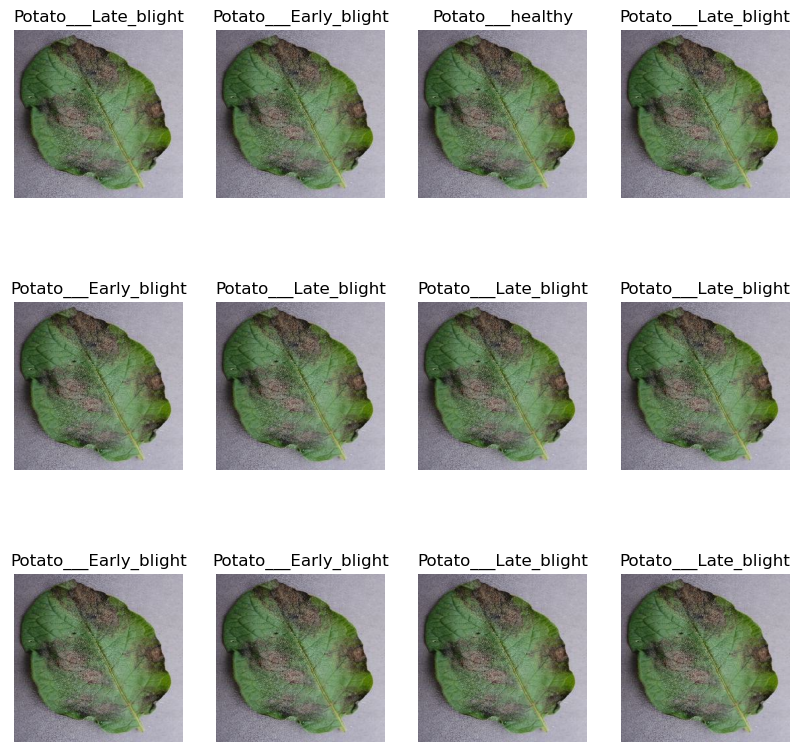

In [22]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range (12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
80% ==> training
20% ==> 10% validation, 10% test

In [24]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [27]:
train_ds= dataset.take(54)
len(train_ds)

54

In [34]:
train_ds = dataset.skip(54)
len(train_ds)

14

In [33]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [32]:
val_ds = train_ds.take(6)
len(val_ds)

6

In [35]:
test_ds = train_ds.skip(6)
len(test_ds)

8

In [58]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds= ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [59]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [60]:
len(train_ds)

54